In [1]:
# importing
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 
import math
from cartopy.util import add_cyclic_point
from sklearn import linear_model as lm
import statsmodels.formula.api as stm

from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors
from matplotlib.gridspec import GridSpec
import seaborn as sns
#import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
#%config InlineBackend.figure_format = 'retina'

import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy import genfromtxt
import matplotlib.cm as cm
from matplotlib import colors

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

mpl.rcParams['hatch.linewidth'] = 0.4
plt.rcParams['hatch.color'] = 'red'
plt.rcParams['hatch.color'] = 'red'
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.size'] = "16"
from matplotlib import rcParams
rcParams["mathtext.default"] = "regular"

import warnings
warnings.filterwarnings(action='ignore')

/dartfs-hpc/rc/home/q/f006fqq/.conda/envs/cl1020/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#directories
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
data_dir = os.path.join(root_dir, 'nsiegert/projects/c4mip/data/resampled_prepped_data')
figure_dir = os.path.join(root_dir, 'clesk/projects/plcl/figs/precip/')
load_dir = os.path.join(root_dir, 'clesk/projects/plcl/data/hydro_deltas/')

time = 'wateryear'

#esm ensemble
current_ensemble = ['BCC-CSM2-MR',
 'CESM2',
 'CMCC-ESM2',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'EC-Earth3-CC',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'NorESM2-LM',
 'UKESM1-0-LL']

# list of experiment names
exp = ['1pctCO2', '1pctCO2-rad', '1pctCO2-bgc', 'nl', 'fullplant']

In [3]:
# load in the land masks for each model (variable sftlf)
# and interpolate the mdl's lai mask from the ensemble mean.
cesm2_landmask = xr.open_dataset(os.path.join(root_dir, 'nsiegert/projects/c4mip/data/download/sftlf/sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc'))
cesm2_landmask = cesm2_landmask.sftlf >= 75

# load ensemble mean lai mask (first30)
ensmean_laimask_first30 = xr.open_dataset(os.path.join(root_dir, 'nsiegert/projects/c4mip/data', 'ens_mean_lai_mask_f30.nc'))
lai_barren_mask = ensmean_laimask_first30.barrenmask

# list to store these mask da's
sftlf_landmask_list = {}
lai_mask_list = {}

# directory with the sftlf files
sftlf_dir = os.path.join(root_dir, 'nsiegert/projects/c4mip/data/download/sftlf')

# loop thru all models
for model in current_ensemble:
    
    # LAND MASK
    
    # open the model's land mask - just grab the first one 
    if model=='EC-Earth3-CC': 
        modelalt='EC-Earth3'   
        model_sftlf_wildcard = 'sftlf*' + modelalt + '*'
    else:
        model_sftlf_wildcard = 'sftlf*' + model + '*'
    
    # glob.glob returns a list I think.
    thismdl_landmasks = glob.glob(os.path.join(sftlf_dir, model_sftlf_wildcard))
    thismdl_landmask = xr.open_dataset(thismdl_landmasks[0])

    # check for this 'type' coord...
    if 'type' in thismdl_landmask.coords:
        # if it has one, drop it.
        thismdl_landmask = thismdl_landmask.drop('type')
    
    thismdl_landmask = thismdl_landmask.assign_coords({'model':model})
    
    # add that to land mask list
    sftlf_landmask_list[model] = (thismdl_landmask.sftlf / 100) # so it's in fraction of cell = land.
    
    # LAI MASK - interp() from ensemble mean lai mask
        
    # Interp LAI MASK
    thismdl_lai_mask = lai_barren_mask.interp_like(thismdl_landmask, method='nearest')
    #thismdl_lai_mask = thismdl_lai_mask.assign_coords({'model': model})
    # add INVERSE to the list (b/c 1 right now = barren. so want 1 to = keep, 0 = drop) 
    lai_mask_list[model] = (~(thismdl_lai_mask.astype('bool')))  
    #lai_mask_list = make_ensemble_concat_ds(lai_mask_list, timedim=False)

In [4]:
# add cyclic point to lai mask, for plotting
dat = lai_barren_mask
lat = lai_barren_mask.coords['lat']
lon = lai_barren_mask.coords['lon']
lon_idx = 1

wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)

lai_barren_mask = xr.DataArray(data=wrap_data, 
                             dims=['lat','lon'],
                             coords=(lat.lat.data,wrap_lon))


### cyclic pt land mask
dat = cesm2_landmask

lat = cesm2_landmask.coords['lat']
lon = cesm2_landmask.coords['lon']
lon_idx = 1

wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)

landmask = xr.DataArray(data=wrap_data, 
                             dims=['lat','lon'],
                             coords=(lat.lat.data,wrap_lon))


#### load data

In [5]:
# load and prep raw time series output for ensemble:

t_list = {}
pr_list = {}
q_list = {}
sm_list = {}
le_list = {}
se_list = {}
lai_list = {}
tas_list = {}

for i,model in enumerate(current_ensemble):
    
    print(model) 
    
    t_list[model] = {}
    pr_list[model] = {}
    q_list[model] = {}
    sm_list[model] = {}
    le_list[model] = {}
    se_list[model] = {}
    lai_list[model] = {}
    tas_list[model] = {}
    
    # load data
    lai_mask = lai_mask_list[model]
    
    for experiment in ['1pctCO2','1pctCO2-bgc','1pctCO2-rad']:
        
        t = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'tran', model, experiment, time))
        pr = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'pr', model, experiment, time))
        q = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrro', model, experiment, time))
        sm = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrso', model, experiment, time))
        le = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'evspsblveg', model, experiment, time))
        se = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'evspsblsoi', model, experiment, time))
        lai = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'lai', model, experiment, time))
        tas = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'tas', model, experiment, time))
        
        pr.coords['mask'] = (('lat','lon'), lai_mask.data)
        t.coords['mask'] = (('lat','lon'), lai_mask.data)
        q.coords['mask'] = (('lat','lon'), lai_mask.data)
        sm.coords['mask'] = (('lat','lon'), lai_mask.data)
        le.coords['mask'] = (('lat','lon'), lai_mask.data)
        se.coords['mask'] = (('lat','lon'), lai_mask.data)
        lai.coords['mask'] = (('lat','lon'), lai_mask.data)
        tas.coords['mask'] = (('lat','lon'), lai_mask.data)

    
        # model specific dimension fixes:
        if model == 'BCC-CSM2-MR':
            pr = pr.drop_sel(water_year=2001)

        t_list[model][experiment] = t
        pr_list[model][experiment] = pr
        q_list[model][experiment] = q
        sm_list[model][experiment] = sm
        le_list[model][experiment] = le 
        se_list[model][experiment] = se
        lai_list[model][experiment] = lai
        tas_list[model][experiment] = tas   



BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
EC-Earth3-CC
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
NorESM2-LM
UKESM1-0-LL


In [6]:
#load regridded deltas for common resolution analyses
deltaT = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaT_abs.nc'))
deltaLE = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLE_abs.nc'))
deltaSE = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSE_abs.nc'))
deltaQ = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaQ_abs.nc'))
deltaSM = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSM_abs.nc'))
deltaP = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaPr_abs.nc'))
deltaLAI = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLAI_abs.nc'))
baseLAI = xr.open_dataset(os.path.join(root_dir,load_dir, 'baseLAI.nc'))
deltaT_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaT_normP.nc'))
deltaLE_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLE_normP.nc'))
deltaSE_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSE_normP.nc'))
deltaQ_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaQ_normP.nc'))
deltaSM_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSM_normP.nc'))



In [7]:
#simple helper functions 
#global mean
def globMean(data):
    return data.weighted(np.cos(np.deg2rad(data.lat))).mean(dim=['lat','lon'],skipna=True)
#global median
def globMedian(data):
    return data.median(dim=['lat','lon'])
#delta
def getDelta(data):
    
    wy_full = data.water_year.values[1:140]
    wy_first30 = wy_full[:30]
    wy_last30 = wy_full[-30:]
    mean_first30 = data.where(data.mask).sel(water_year=wy_first30).mean(dim='water_year')
    mean_last30 = data.where(data.mask).sel(water_year=wy_last30).mean(dim='water_year')
    return mean_last30 - mean_first30

In [10]:
# compute runoff pattern correlations: P-ET, P-T, P, T (all deltas, all as fraction of base P)
experiments = ['1pctCO2','1pctCO2-bgc','1pctCO2-rad']

baseP = {}
baseQ = {}
deltaP_ET = {}
deltaP_T = {}
delta_P = {}
delta_T = {}
delta_Q = {}
baseT_ET = {}
deltaT_ET = {}
delta_SM = {}

q_corr = {}

for experiment in experiments:
    
    baseP[experiment] ={}
    baseQ[experiment] ={}
    deltaP_ET[experiment] = {}
    deltaP_T[experiment] = {}
    delta_P[experiment] = {}
    delta_T[experiment] = {}
    delta_Q[experiment] = {}
    q_corr[experiment] = {}
    baseT_ET[experiment] = {}
    deltaT_ET[experiment] = {}
    delta_SM[experiment] = {}
    
    for model in current_ensemble:

        # P & Q
        baseP[experiment][model] = pr_list[model]['1pctCO2'].where(pr_list[model]['1pctCO2'].mask).sel(water_year=pr_list[model]['1pctCO2'].water_year[:30]).mean(dim='water_year').interp_like(deltaP.sel(experiment='1pctCO2',model=model).deltaPr,method='nearest').pr
        baseQ[experiment][model] = q_list[model]['1pctCO2'].where(q_list[model]['1pctCO2'].mask).sel(water_year=q_list[model]['1pctCO2'].water_year[:30]).mean(dim='water_year').interp_like(deltaQ.sel(experiment='1pctCO2',model=model).deltaQ,method='nearest').mrro
        
        deltaP_ET[experiment][model] = (1 / baseP[experiment][model]) * (deltaP.sel(experiment=experiment,model=model).deltaPr -\
                             deltaT.sel(experiment=experiment,model=model).deltaT -\
                             deltaLE.sel(experiment=experiment,model=model).deltaLE - \
                             deltaSE.sel(experiment=experiment,model=model).deltaSE)

        deltaP_T[experiment][model] = (1 / baseP[experiment][model]) * (deltaP.sel(experiment=experiment,model=model).deltaPr - deltaT.sel(experiment=experiment,model=model).deltaT)

        delta_P[experiment][model] = deltaP.sel(experiment=experiment,model=model).deltaPr / baseP[experiment][model]
        delta_T[experiment][model] = deltaT.sel(experiment=experiment,model=model).deltaT / baseP[experiment][model]
        delta_Q[experiment][model] = deltaQ.sel(experiment=experiment,model=model).deltaQ / baseP[experiment][model]
        delta_SM[experiment][model] = deltaSM.sel(experiment=experiment,model=model).deltaSM / baseP[experiment][model]

        # correlations
        q_corr[experiment][model] = {}
        q_corr[experiment][model]['r(P-ET,Q)'] = xr.corr(delta_Q[experiment][model],deltaP_ET[experiment][model]).data
        q_corr[experiment][model]['r(P-T,Q)'] = xr.corr(delta_Q[experiment][model],deltaP_T[experiment][model]).data
        q_corr[experiment][model]['r(P,Q)'] = xr.corr(delta_Q[experiment][model],delta_P[experiment][model]).data
        q_corr[experiment][model]['r(T,Q)'] = xr.corr(delta_Q[experiment][model],delta_T[experiment][model]).data
        #q_corr[experiment][model]['baseT_ET'] = float(globMean(baseT_ET[experiment][model]))
        #q_corr[experiment][model]['deltaT_ET'] = float(globMean(deltaT_ET[experiment][model]))
        q_corr[experiment][model]['deltaQ'] = float(globMean(deltaQ.sel(experiment=experiment,model=model).deltaQ))
        q_corr[experiment][model]['r(SM,Q)'] = xr.corr(delta_Q[experiment][model],delta_SM[experiment][model]).data
        q_corr[experiment][model]['r(P-ET,SM)'] = xr.corr(delta_SM[experiment][model],deltaP_ET[experiment][model]).data
        q_corr[experiment][model]['r(P-T,SM)'] = xr.corr(delta_SM[experiment][model],deltaP_T[experiment][model]).data
        q_corr[experiment][model]['r(P,SM)'] = xr.corr(delta_SM[experiment][model],delta_P[experiment][model]).data
        q_corr[experiment][model]['r(T,SM)'] = xr.corr(delta_SM[experiment][model],delta_T[experiment][model]).data

qrctl = pd.DataFrame.from_dict(q_corr['1pctCO2']).transpose()
qrbgc = pd.DataFrame.from_dict(q_corr['1pctCO2-bgc']).transpose()
qrrad = pd.DataFrame.from_dict(q_corr['1pctCO2-rad']).transpose()
#qrrad = pd.DataFrame.from_dict(q_corr['nl']).transpose()



In [11]:
### ensemble mean pattern corr
dP_ETensmean = xr.concat([deltaP_ET['1pctCO2-bgc'][model] for model in current_ensemble],dim='model').mean(dim='model')
dP_Tensmean = xr.concat([deltaP_T['1pctCO2-bgc'][model] for model in current_ensemble],dim='model').mean(dim='model')
dQensmean = xr.concat([delta_Q['1pctCO2-bgc'][model] for model in current_ensemble],dim='model').mean(dim='model')
delta_Pens = xr.concat([delta_P['1pctCO2-bgc'][model] for model in current_ensemble],dim='model')
delta_Pensmean = delta_Pens.mean(dim='model')

### pattern correlation on ensemble mean
xr.corr(dQensmean,dP_Tensmean)

<xarray.DataArray ()>
array(0.53584799)

### Figure 2

In [12]:
# ensemble agreement
def qt_ensemble_agreement(data, e, thresh_agree=2/3):
    """
    This function takes in ensemble var deltas and classifies ensemble agreement on sign of change.  
    Currently, within model change definition is defined as <-0.5SD or >0.5SD, parameter 'tol'. No change is between -0.5 and 0.5 SD.
    Agreement is defined as at least two thirds of models showing that change (+, -, no change)
    The classification codes:
    -agree negative as 0 (if fraction models agree neg > thresh_agree)
    -1 if agree no change
    -2 if agree +
    -3 if disagree (less than two-thirds agreement on either +, -, or no change)
    
    Params:
    ------
        var_std_deltas_list (list of xr datasets with standardized deltas (can be non-standardized too)
        
        tol (tolerance about zero for +, -, or no change, in SD)
        
        thresh_agree (fraction of models that must agree on +, -, or no change, else classify as disagree)
        
    Returns:
    -------
        xarray DS's of agreement for each experiment above        
    """    
    #varname = list(dict(data.data_vars).keys())[0]
    agreement_ds_list = []
    
    # # loop over expriments
    # for e in exp:


    # compute fractional agreement (N models >/< tol)
    agree0 = data==0
    frac_agree0 = agree0.sum(dim='model')/len(current_ensemble)
    agree1 = data==1
    frac_agree1 = agree1.sum(dim='model')/len(current_ensemble)
    agree2 = data==2
    frac_agree2 = agree2.sum(dim='model')/len(current_ensemble)
    agree3 = data==3
    frac_agree3 = agree3.sum(dim='model')/len(current_ensemble)
    agree4 = data==4
    frac_agree4 = agree4.sum(dim='model')/len(current_ensemble)

    # agree6 = data==6
    # frac_agree6 = agree6.sum(dim='model')/len(current_ensemble)
    # agree7 = data==7
    # frac_agree7 = agree7.sum(dim='model')/len(current_ensemble)
    # agree8 = data==8
    # frac_agree8 = agree8.sum(dim='model')/len(current_ensemble)
    # classify agreement

    #agree_map = #0 if fraction models agree neg > thresh_agree, 1 if agree noc, 2 if agree +, 3 if disagree
    agreement=np.nan*np.zeros([data.lat.shape[0],data.lon.shape[0]])
    #agreement[frac_agree0>=thresh_agree] = 0    
    agreement[frac_agree1>=thresh_agree] = 0
    agreement[frac_agree2>=thresh_agree] = 1
    agreement[frac_agree3>=thresh_agree] = 2
    agreement[frac_agree4>=thresh_agree] = 3
   
    # agreement[frac_agree6>thresh_agree] = 6
    # agreement[frac_agree7>thresh_agree] = 7
    # agreement[frac_agree8>thresh_agree] = 8
    agreement[(frac_agree1<thresh_agree) & (frac_agree2<thresh_agree) & (frac_agree3<thresh_agree) & (frac_agree4<thresh_agree) ] = 4

    # put agreement in a new ds
    dvs = {'agreement':(['lat','lon'],agreement)}
    crds = {'lon':(['lon'],data.lon.data),'lat':(['lat'],data.lat.data),'experiment':e}

    ds_agreement = xr.Dataset(data_vars=dvs,coords=crds)

        #save agreement for this expriment
        #agreement_ds_list.append(ds_agreement)

    # concat all those ds's along the 'model' dim, 
    #all_agreement_ds = xr.concat(agreement_ds_list, dim='experiment')
    
    return ds_agreement

In [13]:
# classification area fraction functions
def caseAreaFrac(data):
    
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data
    case_frac = []
   # zero_area = (data==0).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(qt[model].lat))).sum(dim=['lat','lon']).data 
    
    for b in range(1,len(clrs_qt)+1):

        case_area = (data==b).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
        case_frac.append(case_area/total_area)

    return [cf/sum(case_frac) for cf in case_frac]

def agrAreaFrac(data):
    case_frac = []

    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data

    for b in range(0,len(clrs_qt)+1):

        case_area = (data==b).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).agreement.data
        case_frac.append((case_area/total_area))

    return [(cf/sum(case_frac)).round(2) for cf in case_frac]

In [14]:
#execute classification based on sign of runoff and transpiration change
experiment = '1pctCO2-bgc'
qt = {}
tol = 0

for i,model in enumerate(current_ensemble):
    
    dT = deltaT.sel(model=model,experiment=experiment).deltaT
    dQ = deltaQ.sel(model=model,experiment=experiment).deltaQ
    
    c1 = (dQ>=tol) & (dT<-tol)   
    c2 = 2 * ((dQ<-tol) & (dT<-tol))
    c3 = 3 * ((dQ>=tol) & (dT>=tol))
    c4 = 4 * ((dQ<-tol) & (dT>=tol))

    
    qt[model] = c1+c2+c3+c4
    

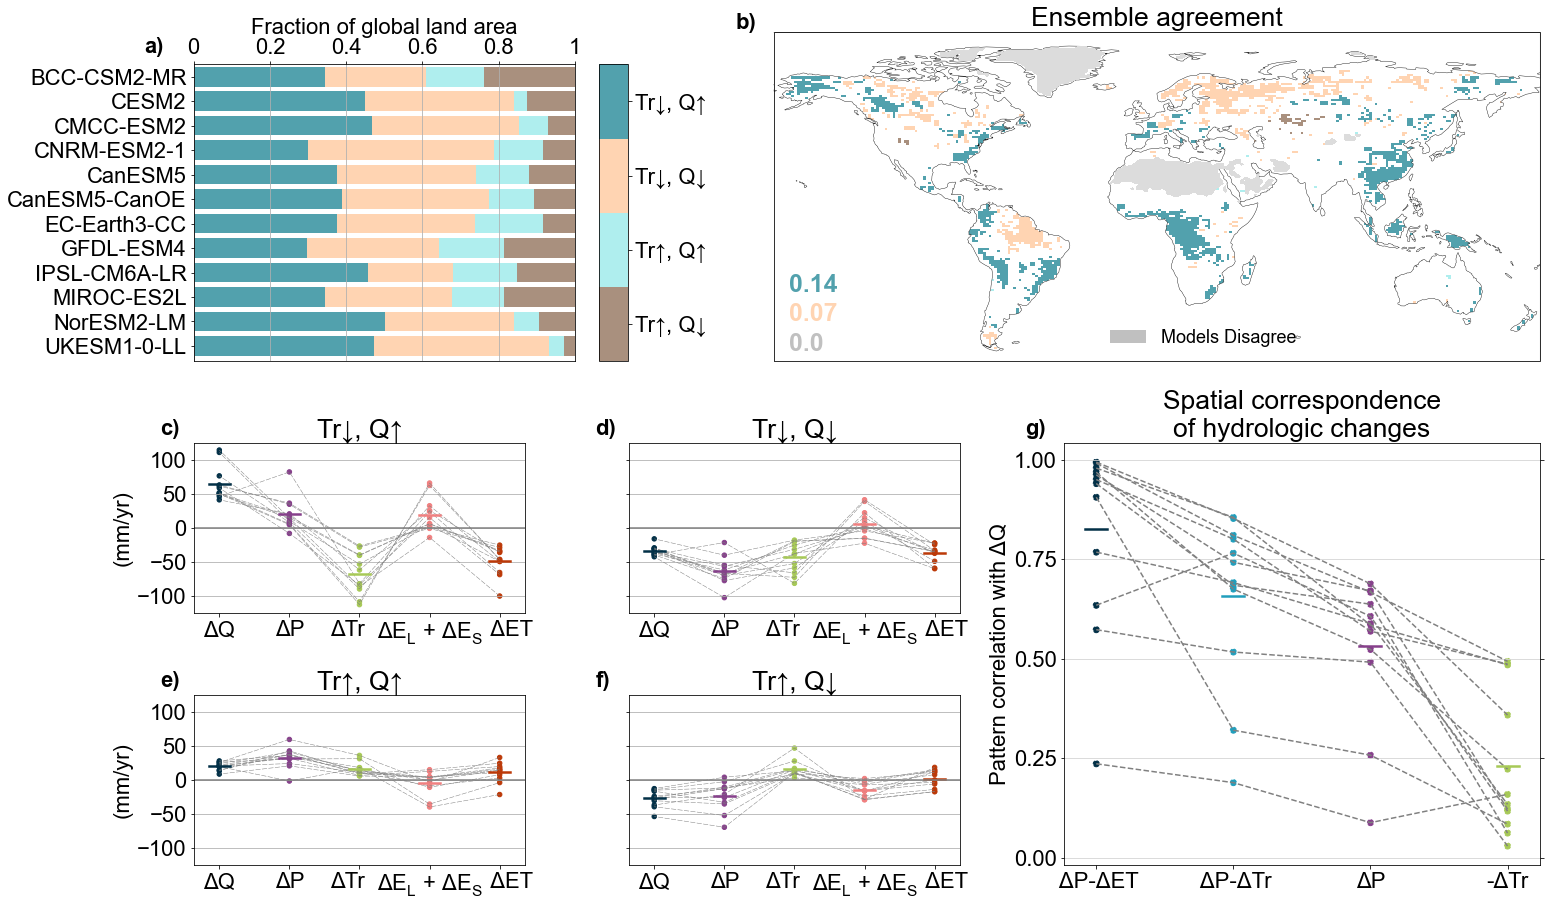

In [157]:
fsize = 22
mpl.rcParams['font.size'] = fsize


caselabs = ['Tr↓, Q↑','Tr↓, Q↓','Tr↑, Q↑','Tr↑, Q↓']

clrs_qt = ['#52A1AD','#FFD4B2','paleturquoise','#A9907E']

#clrs_qt.reverse()
cmap_qt = mpl.colors.ListedColormap(clrs_qt) 
# define the bins and normalize
bounds = np.linspace(0, len(clrs_qt),len(clrs_qt)+1)
norm_qt = mpl.colors.BoundaryNorm(bounds, cmap_qt.N)

fig = plt.figure(figsize=(22,14))

axs = []
gs = GridSpec(8, 10)

axs.append(fig.add_subplot(gs[1:4, :4]))
axs.append(fig.add_subplot(gs[:4, 4:],projection=ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[4:6, :3]))
axs.append(fig.add_subplot(gs[4:6, 3:6]))
axs.append(fig.add_subplot(gs[6:8, :3]))
axs.append(fig.add_subplot(gs[6:8, 3:6]))
axs.append(fig.add_subplot(gs[4:8, 6:]))
    

### a) area fraction case by model
ax = axs[0]

for i,model in enumerate(current_ensemble):
    caseareafrac = caseAreaFrac(qt[model])
    ax.barh(i,caseareafrac[0],color=clrs_qt[0])
    ax.barh(i,caseareafrac[1],left=caseareafrac[0],color=clrs_qt[1])
    ax.barh(i,caseareafrac[2],left=sum(caseareafrac[0:2]),color=clrs_qt[2])
    ax.barh(i,caseareafrac[3],left=sum(caseareafrac[0:3]),color=clrs_qt[3])

ax.set_yticks(np.arange(0,len(current_ensemble),1))
ax.set_yticklabels(current_ensemble)
ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_xlim([0,1])
ax.set_ylim([-0.5,len(current_ensemble)-0.4])
ax.set_xlabel('Fraction of global land area')
ax.invert_yaxis()

qtsm = plt.cm.ScalarMappable(norm=norm_qt,cmap=cmap_qt)
cb = plt.colorbar(qtsm,ax=ax,aspect=10)
cb.ax.set_yticks([0.5,1.5,2.5,3.5])
cb.ax.set_yticklabels(caselabs,rotation=0);
cb.ax.invert_yaxis()

ax.text(-0.13,1.04,'a)',transform=ax.transAxes,fontweight='bold')
ax.set(anchor=(0.2,-0.1))

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.grid(axis='x')

### b) agreement
ax = axs[1]
qtcat = xr.concat([qt[model] for model in current_ensemble],dim='model')
qt_agr = qt_ensemble_agreement(qtcat,experiment)

clrs_qtag = clrs_qt+['silver']
cmap_qtag = mpl.colors.ListedColormap(clrs_qtag) 
bounds = np.linspace(0, len(clrs_qtag),len(clrs_qtag)+1)
norm_qtag = mpl.colors.BoundaryNorm(bounds, cmap_qtag.N)

pl = qt_agr.agreement.plot(transform=ccrs.PlateCarree(),ax=ax,cmap=cmap_qtag,norm=norm_qtag,add_colorbar=False)
ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) 

b0 = ax.bar(0,0,color='silver')
ax.legend([b0[0]],['Models Disagree'],loc=(0.43,0.02),fontsize=18,frameon=False)

ax.set(anchor=(-13,0))
ax.text(-0.05,1.01,'b)',transform=ax.transAxes,fontweight='bold')
ax.set_title('Ensemble agreement')

offset = 0.09

for i,b in enumerate([0,1,4]):
    ax.text(0.02,0.12-(i-1)*offset,agrAreaFrac(qt_agr)[b],transform=ax.transAxes,weight='bold',color=clrs_qtag[b],fontsize=25)

# ax.text(0.02,0.23,agrAreaFrac(qt_agr)[1],transform=ax.transAxes,weight='bold',color='darkturquoise',fontsize=22)
# ax.text(0.02,0.15,agrAreaFrac(qt_agr)[2],transform=ax.transAxes,weight='bold',color='#FFD289',fontsize=22)
# ax.text(0.02,0.07,np.round(1-sum(agrAreaFrac(qt_agr)),2),transform=ax.transAxes,weight='bold',color='darkgrey',fontsize=22)

### c) - f) budgets
le_col = '#219ebc'
t_col = '#a7c957'
se_col = '#bc6c25'
total_col = '#023047'
p_col = '#86408b'
q_col = 'lightcoral'
sm_col = 'slategrey'
vpd_col = '#bc3908'

colors = [total_col,p_col,t_col,'lightcoral',vpd_col]

lets = ['c)','d)','e)','f)']

rowtitles = ['(mm/yr)','','(mm/yr)','']

ylims = [-0.2,0.2]
ylims = [-125,125]

cases = range(1,5)
    
for ic,case in enumerate(cases):

    ax = axs[ic+2]
    dTcase = xr.concat([deltaT.sel(model=model, experiment=experiment).where(qt[model] == case).deltaT for model in current_ensemble],dim='model')
    dLcase = xr.concat([deltaLE.sel(model=model, experiment=experiment).where(qt[model] == case).deltaLE for model in current_ensemble],dim='model')
    dScase = xr.concat([deltaSE.sel(model=model, experiment=experiment).where(qt[model] == case).deltaSE for model in current_ensemble],dim='model')
    dPcase = xr.concat([deltaP.sel(model=model, experiment=experiment).where(qt[model] == case).deltaPr for model in current_ensemble],dim='model')
    dQcase = xr.concat([deltaQ.sel(model=model, experiment=experiment).where(qt[model] == case).deltaQ for model in current_ensemble],dim='model')
    dETcase = xr.concat([sum([dTcase.sel(model=model),dLcase.sel(model=model),dScase.sel(model=model)]) for model in current_ensemble],dim='model')
    dLScase = xr.concat([sum([dLcase.sel(model=model),dScase.sel(model=model)]) for model in current_ensemble],dim='model')

    dat = [dQcase,dPcase,dTcase,dLScase,dETcase]
    x = np.arange(1,len(dat)+1,1)
    y = [globMean(d) for d in dat]
    ensmeans = [np.mean([globMean(d.sel(model=model)) for model in current_ensemble]) for d in dat]

    for model in current_ensemble:
        y = [globMean(d.sel(model=model)) for d in dat]
        ax.scatter(x,y,s=20,color=colors)
        ax.plot(x,y,linestyle=(5,(10,3)),color='gray',linewidth=0.5)
    
    for i in range(len(dat)):
        ax.plot([x[i]-0.15,x[i]+0.15],[ensmeans[i],ensmeans[i]],color=colors[i],linewidth=2.5)

    ax.set_xticks(x)
    ax.set_yticks([-100,-50,0,50,100])
    if ic in [1,3]:
        ax.set_yticklabels('')

    ax.set_xticklabels(['ΔQ','ΔP','ΔTr    ',r'$ΔE_L$ + $ΔE_S$','    ΔET'])#,'$ΔfQ_s$']);
    ax.axhline(0,color='grey')
    #ax.set_ylim(-130,110)
    ax.set_ylabel(rowtitles[ic])
    ax.set_ylim(ylims)
    ax.set_title(caselabs[ic])
    ax.set_anchor((-0.5,0.2))
    ax.text(-0.1,1.05,lets[ic],transform=ax.transAxes,fontweight='bold')
    ax.grid(axis='y')
    
### f) pattern correlation
ax = axs[-1]
vs = ['r(P-ET,Q)','r(P-Tr,Q)','r(P,Q)','r(Tr,Q)']
xlabs = [' ΔP-ΔET',' ΔP-ΔTr','ΔP','-ΔTr']

x = np.arange(0,4,1)
rcolors =  [total_col,le_col,p_col,t_col]
for model in current_ensemble:
    ax.scatter(x,qrbgc.loc[model][0:4]*[1,1,1,-1],color=rcolors,linestyle='--')
    ax.plot(x,qrbgc.loc[model][0:4]*[1,1,1,-1],color='grey',linestyle='--')

qrmeans = qrbgc.mean()[:4].abs()
for ix in x:
    ax.plot([ix-0.08,ix+0.08],[qrmeans[ix],qrmeans[ix]],color=rcolors[ix],linewidth=2.5)
    
ax.set_xticks(x)        
ax.set_xticklabels(xlabs)
ax.set_ylabel(r'Pattern correlation with ΔQ')
ax.text(-0.08,1.02,'g)',transform=ax.transAxes,fontweight='bold')
ax.set_title('Spatial correspondence\nof hydrologic changes')
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.grid(axis='y',color='lightgrey')
ax.yaxis.set_ticks_position('both')

fig.canvas.draw()
plt.tight_layout()

#plt.savefig(figure_dir + 'fig2.pdf')
#plt.savefig(figure_dir + 'fig2.png')


Figure 2 with tolerance for agreement

In [35]:
#AGREEMENT
def qt_ensemble_agreement(data, e, thresh_agree=2/3):
    """
    This function takes in ensemble var deltas and classifies ensemble agreement on sign of change.  
    Currently, within model change definition is defined as <-0.5SD or >0.5SD, parameter 'tol'. No change is between -0.5 and 0.5 SD.
    Agreement is defined as at least two thirds of models showing that change (+, -, no change)
    The classification codes:
    -agree negative as 0 (if fraction models agree neg > thresh_agree)
    -1 if agree no change
    -2 if agree +
    -3 if disagree (less than two-thirds agreement on either +, -, or no change)
    
    Params:
    ------
        var_std_deltas_list (list of xr datasets with standardized deltas (can be non-standardized too)
        
        tol (tolerance about zero for +, -, or no change, in SD)
        
        thresh_agree (fraction of models that must agree on +, -, or no change, else classify as disagree)
        
    Returns:
    -------
        xarray DS's of agreement for each experiment above        
    """    
    #varname = list(dict(data.data_vars).keys())[0]
    agreement_ds_list = []
    
    # # loop over expriments
    # for e in exp:


    # compute fractional agreement (N models >/< tol)
    agree0 = data==0
    frac_agree0 = agree0.sum(dim='model')/len(current_ensemble)
    agree1 = data==1
    frac_agree1 = agree1.sum(dim='model')/len(current_ensemble)
    agree2 = data==2
    frac_agree2 = agree2.sum(dim='model')/len(current_ensemble)
    agree3 = data==3
    frac_agree3 = agree3.sum(dim='model')/len(current_ensemble)
    agree4 = data==4
    frac_agree4 = agree4.sum(dim='model')/len(current_ensemble)
    agree5 = data==5
    frac_agree5 = agree5.sum(dim='model')/len(current_ensemble)

    # agree6 = data==6
    # frac_agree6 = agree6.sum(dim='model')/len(current_ensemble)
    # agree7 = data==7
    # frac_agree7 = agree7.sum(dim='model')/len(current_ensemble)
    # agree8 = data==8
    # frac_agree8 = agree8.sum(dim='model')/len(current_ensemble)
    # classify agreement

    #agree_map = #0 if fraction models agree neg > thresh_agree, 1 if agree noc, 2 if agree +, 3 if disagree
    agreement=np.nan*np.zeros([data.lat.shape[0],data.lon.shape[0]])
    #agreement[frac_agree0>=thresh_agree] = 0    
    agreement[frac_agree1>=thresh_agree] = 0
    agreement[frac_agree2>=thresh_agree] = 1
    agreement[frac_agree3>=thresh_agree] = 2
    agreement[frac_agree4>=thresh_agree] = 3
    agreement[frac_agree5>=thresh_agree] = 4
    # agreement[frac_agree6>thresh_agree] = 6
    # agreement[frac_agree7>thresh_agree] = 7
    # agreement[frac_agree8>thresh_agree] = 8
    agreement[(frac_agree1<thresh_agree) & (frac_agree2<thresh_agree) & (frac_agree3<thresh_agree) & (frac_agree4<thresh_agree) & (frac_agree5<thresh_agree)] = 5

    # put agreement in a new ds
    dvs = {'agreement':(['lat','lon'],agreement)}
    crds = {'lon':(['lon'],data.lon.data),'lat':(['lat'],data.lat.data),'experiment':e}

    ds_agreement = xr.Dataset(data_vars=dvs,coords=crds)

        #save agreement for this expriment
        #agreement_ds_list.append(ds_agreement)

    # concat all those ds's along the 'model' dim, 
    #all_agreement_ds = xr.concat(agreement_ds_list, dim='experiment')
    
    return ds_agreement

def agrAreaFrac(data):
    case_frac = []

    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data

    for b in range(0,len(clrs_qtag)+1):

        case_area = (data==b).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).agreement.data
        case_frac.append((case_area/total_area))

    return [(cf/sum(case_frac)).round(2) for cf in case_frac]

In [36]:


t_listb = {}
q_listb = {}

for i,model in enumerate(current_ensemble):
    
    t_listb[model] = {}
    q_listb[model] = {}
    
    # load data
    lai_mask = lai_mask_list[model]
    
    for experiment in ['1pctCO2']:
        
        t = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'tran', model, experiment, time))
        pr = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'pr', model, experiment, time))
        sm = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrso', model, experiment, time))
        q = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrro', model, experiment, time))
        
        t.coords['mask'] = (('lat','lon'), lai_mask.data)
        pr.coords['mask'] = (('lat','lon'), lai_mask.data)
        sm.coords['mask'] = (('lat','lon'), lai_mask.data)
        q.coords['mask'] = (('lat','lon'), lai_mask.data)

        # model specific dimension fixes:
        if model == 'BCC-CSM2-MR':
            pr = pr.drop_sel(water_year=2001)

        t_listb[model] = t
        q_listb[model] = q
        

In [37]:
def cycregrid(da):

    varname = list(dict(da.data_vars).keys())[0]
    datrep = da.sel(lon=da.lon[-4])[varname].values
    dat = da[varname]
    dat[:,-1] = datrep+0.000001
    dat[:,-2] = datrep+0.000002
    dat[:,-3] = datrep+0.000002

    cycdat = xr.DataArray(data=dat,
                              dims=['lat','lon'],
                              coords=(da.lat.data,da.lon.data))

    return cycdat

In [63]:
baseT = []
baseQ = []
sdT = []
sdQ = []

for i,model in enumerate(current_ensemble):

    baseT.append(t_listb[model].where(t_listb[model].mask).sel(water_year=t_listb[model].water_year[2:32]).mean(dim='water_year').interp_like(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT,method='nearest').tran)
    baseQ.append(q_listb[model].where(q_listb[model].mask).sel(water_year=q_listb[model].water_year[2:32]).mean(dim='water_year').interp_like(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ,method='nearest').mrro)
    
    sdrgrdT = t_listb[model].where(t_listb[model].mask).sel(water_year=t_listb[model].water_year[2:32]).std(dim='water_year').interp_like(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT,method='nearest')
    sdT.append(cycregrid(sdrgrdT))
    sdrgrdQ = q_listb[model].where(q_listb[model].mask).sel(water_year=q_listb[model].water_year[2:32]).std(dim='water_year').interp_like(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ,method='nearest')
    sdQ.append(cycregrid(sdrgrdQ))

baseT = xr.concat(baseT,dim='model')
baseQ = xr.concat(baseQ,dim='model')

sdT = xr.concat(sdT,dim='model')
sdQ = xr.concat(sdQ,dim='model')

In [64]:
deltaTp = deltaT.sel(experiment=experiment).deltaT/sdT
deltaQp = deltaQ.sel(experiment=experiment).deltaQ/sdQ 


In [155]:
experiment = '1pctCO2-bgc'
qt = {}
tol = 0

for i,model in enumerate(current_ensemble):
    
    dT = deltaT.sel(model=model,experiment=experiment).deltaT
    dQ = deltaQ.sel(model=model,experiment=experiment).deltaQ
    
    c1 = (dQ>=tol) & (dT<-tol)   
    c2 = 2 * ((dQ<-tol) & (dT<-tol))
    c3 = 3 * ((dQ>=tol) & (dT>=tol))
    c4 = 4 * ((dQ<-tol) & (dT>=tol))

    
    qt[model] = c1+c2+c3+c4
    

In [65]:
experiment = '1pctCO2-bgc'
qttol = {}
tol = 0.25

for i,model in enumerate(current_ensemble):
    
    dTp = deltaTp.sel(model=model)
    dQp = deltaQp.sel(model=model)
    
    c1 = (dQp>=tol) & (dTp<-tol)   
    c2 = 2 * ((dQp<-tol) & (dTp<-tol))
    c3 = 3 * ((dQp>=tol) & (dTp>=tol))
    c4 = 4 * ((dQp<-tol) & (dTp>=tol))
    c5 = 5 * ((abs(dQp)<tol))# & (dTp<-tol))

    
    qttol[model] = c1+c2+c3+c4+c5
    

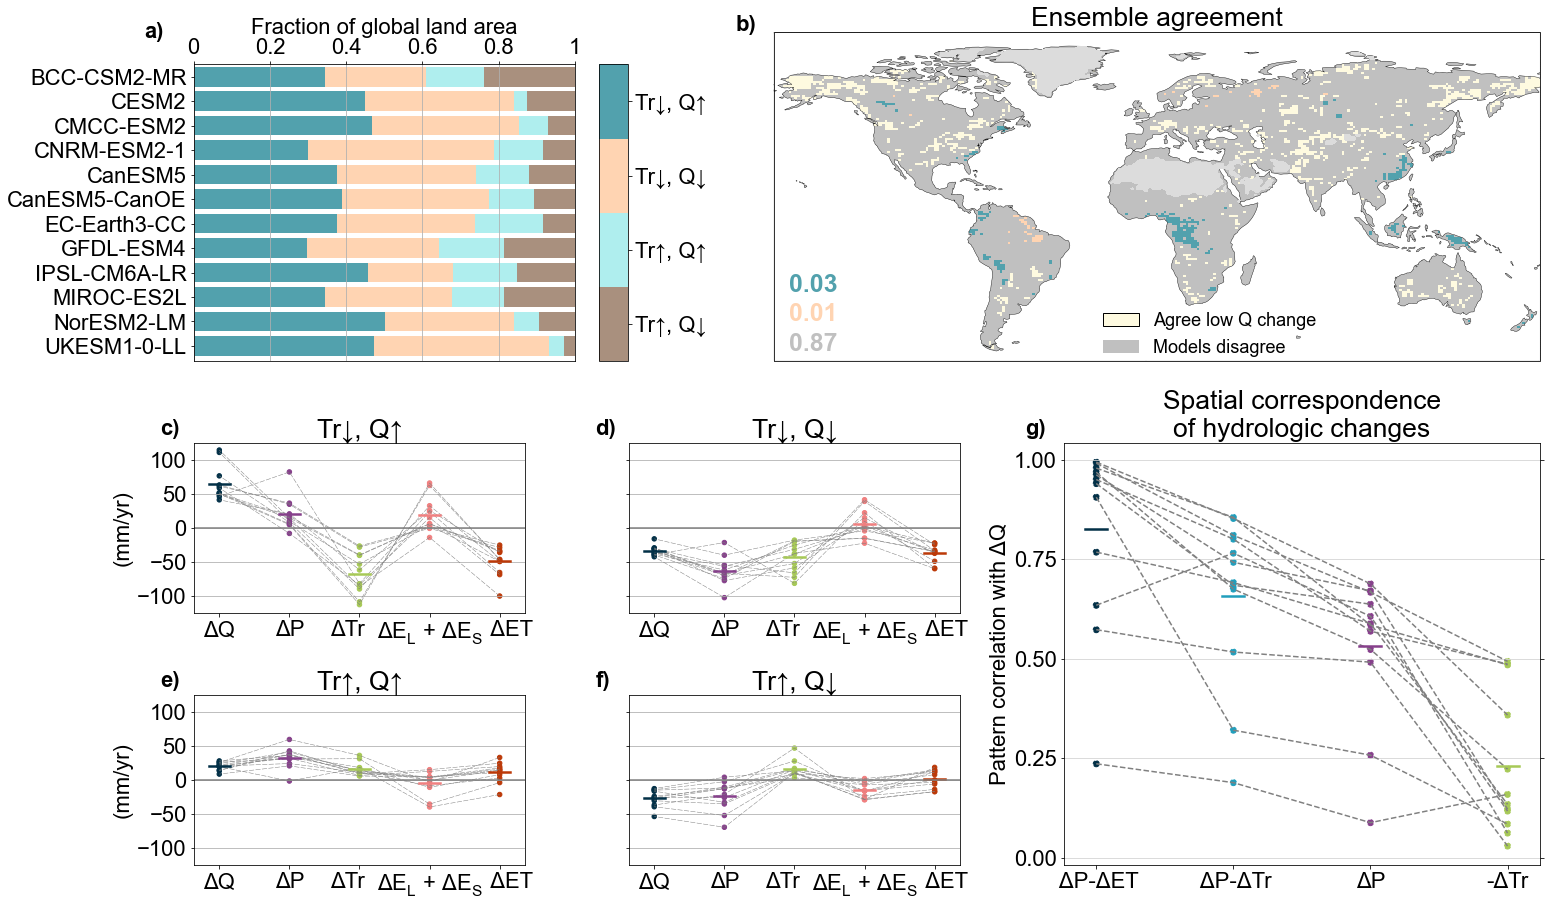

In [69]:
fsize = 22
mpl.rcParams['font.size'] = fsize


caselabs = ['Tr↓, Q↑','Tr↓, Q↓','Tr↑, Q↑','Tr↑, Q↓']

clrs_qt = ['#52A1AD','#FFD4B2','paleturquoise','#A9907E']

#clrs_qt.reverse()
cmap_qt = mpl.colors.ListedColormap(clrs_qt) 
# define the bins and normalize
bounds = np.linspace(0, len(clrs_qt),len(clrs_qt)+1)
norm_qt = mpl.colors.BoundaryNorm(bounds, cmap_qt.N)

fig = plt.figure(figsize=(22,14))

axs = []
gs = GridSpec(8, 10)

axs.append(fig.add_subplot(gs[1:4, :4]))
axs.append(fig.add_subplot(gs[:4, 4:],projection=ccrs.PlateCarree()))
axs.append(fig.add_subplot(gs[4:6, :3]))
axs.append(fig.add_subplot(gs[4:6, 3:6]))
axs.append(fig.add_subplot(gs[6:8, :3]))
axs.append(fig.add_subplot(gs[6:8, 3:6]))
axs.append(fig.add_subplot(gs[4:8, 6:]))
    

### a) area fraction case by model
ax = axs[0]

for i,model in enumerate(current_ensemble):
    caseareafrac = caseAreaFrac(qt[model])
    ax.barh(i,caseareafrac[0],color=clrs_qt[0])
    ax.barh(i,caseareafrac[1],left=caseareafrac[0],color=clrs_qt[1])
    ax.barh(i,caseareafrac[2],left=sum(caseareafrac[0:2]),color=clrs_qt[2])
    ax.barh(i,caseareafrac[3],left=sum(caseareafrac[0:3]),color=clrs_qt[3])

ax.set_yticks(np.arange(0,len(current_ensemble),1))
ax.set_yticklabels(current_ensemble)
ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_xlim([0,1])
ax.set_ylim([-0.5,len(current_ensemble)-0.4])
ax.set_xlabel('Fraction of global land area')
ax.invert_yaxis()

qtsm = plt.cm.ScalarMappable(norm=norm_qt,cmap=cmap_qt)
cb = plt.colorbar(qtsm,ax=ax,aspect=10)
cb.ax.set_yticks([0.5,1.5,2.5,3.5])
cb.ax.set_yticklabels(caselabs,rotation=0);
cb.ax.invert_yaxis()

ax.text(-0.13,1.09,'a)',transform=ax.transAxes,fontweight='bold')
ax.set(anchor=(0.2,-0.1))

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.grid(axis='x')

### b) agreement
ax = axs[1]
qtcat = xr.concat([qttol[model] for model in current_ensemble],dim='model')
qt_agr = qt_ensemble_agreement(qtcat,experiment)

clrs_qtag = ['#52A1AD','#FFD4B2','paleturquoise','#A9907E','#fefae0','silver']
cmap_qtag = mpl.colors.ListedColormap(clrs_qtag) 
bounds = np.linspace(0, len(clrs_qtag),len(clrs_qtag)+1)
norm_qtag = mpl.colors.BoundaryNorm(bounds, cmap_qtag.N)

pl = qt_agr.agreement.plot(transform=ccrs.PlateCarree(),ax=ax,cmap=cmap_qtag,norm=norm_qtag,add_colorbar=False)
ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) 

b0 = ax.bar(0,0,color='silver')
b1 = ax.bar(0,0,color='#fefae0')

b1.patches[0].set_edgecolor('black')
l1 = ax.legend([b1[0],b0[0]],['Agree low Q change','Models disagree'],loc=(0.42,-0.01),fontsize=18,frameon=False)



ax.set(anchor=(-13,0))
ax.text(-0.05,1.005,'b)',transform=ax.transAxes,fontweight='bold')
ax.set_title('Ensemble agreement')

offset = 0.09

agrf = agrAreaFrac(qt_agr)
#round up tr down Q down to 1% so rounding sums to unity
agrf[1] = 0.01

for i,b in enumerate([0,1,5]):
    ax.text(0.02,0.12-(i-1)*offset,agrf[b],transform=ax.transAxes,weight='bold',color=clrs_qtag[b],fontsize=25)

### c) - f) water budgets for 4 cases
#define colors and labels
le_col = '#219ebc'
t_col = '#a7c957'
se_col = '#bc6c25'
total_col = '#023047'
p_col = '#86408b'
q_col = 'lightcoral'
sm_col = 'slategrey'
vpd_col = '#bc3908'

colors = [total_col,p_col,t_col,'lightcoral',vpd_col]
lets = ['c)','d)','e)','f)']
rowtitles = ['(mm/yr)','','(mm/yr)','']

ylims = [-0.2,0.2]
ylims = [-125,125]

# loop cases
cases = range(1,5)
for ic,case in enumerate(cases):

    ax = axs[ic+2]
    dTcase = xr.concat([deltaT.sel(model=model, experiment=experiment).where(qt[model] == case).deltaT for model in current_ensemble],dim='model')
    dLcase = xr.concat([deltaLE.sel(model=model, experiment=experiment).where(qt[model] == case).deltaLE for model in current_ensemble],dim='model')
    dScase = xr.concat([deltaSE.sel(model=model, experiment=experiment).where(qt[model] == case).deltaSE for model in current_ensemble],dim='model')
    dPcase = xr.concat([deltaP.sel(model=model, experiment=experiment).where(qt[model] == case).deltaPr for model in current_ensemble],dim='model')
    dQcase = xr.concat([deltaQ.sel(model=model, experiment=experiment).where(qt[model] == case).deltaQ for model in current_ensemble],dim='model')
    dETcase = xr.concat([sum([dTcase.sel(model=model),dLcase.sel(model=model),dScase.sel(model=model)]) for model in current_ensemble],dim='model')
    dLScase = xr.concat([sum([dLcase.sel(model=model),dScase.sel(model=model)]) for model in current_ensemble],dim='model')
    dat = [dQcase,dPcase,dTcase,dLScase,dETcase]
    
    x = np.arange(1,len(dat)+1,1)
    y = [globMean(d) for d in dat]
    ensmeans = [np.mean([globMean(d.sel(model=model)) for model in current_ensemble]) for d in dat]

    for model in current_ensemble:
        y = [globMean(d.sel(model=model)) for d in dat]
        ax.scatter(x,y,s=20,color=colors)
        ax.plot(x,y,linestyle=(5,(10,3)),color='gray',linewidth=0.5)
    
    for i in range(len(dat)):
        ax.plot([x[i]-0.15,x[i]+0.15],[ensmeans[i],ensmeans[i]],color=colors[i],linewidth=2.5)

    ax.set_xticks(x)
    ax.set_yticks([-100,-50,0,50,100])
    if ic in [1,3]:
        ax.set_yticklabels('')

    ax.set_xticklabels(['ΔQ','ΔP','ΔTr    ',r'$ΔE_L$ + $ΔE_S$','    ΔET'])#,'$ΔfQ_s$']);
    ax.axhline(0,color='grey')
    #ax.set_ylim(-130,110)
    ax.set_ylabel(rowtitles[ic])
    ax.set_ylim(ylims)
    ax.set_title(caselabs[ic])
    ax.set_anchor((-0.5,0.2))
    ax.text(-0.1,1.05,lets[ic],transform=ax.transAxes,fontweight='bold')
    ax.grid(axis='y')
    
### g) pattern correlation
ax = axs[-1]
vs = ['r(P-ET,Q)','r(P-Tr,Q)','r(P,Q)','r(Tr,Q)']
xlabs = [' ΔP-ΔET',' ΔP-ΔTr','ΔP','-ΔTr']

x = np.arange(0,4,1)
rcolors =  [total_col,le_col,p_col,t_col]
for model in current_ensemble:
    ax.scatter(x,qrbgc.loc[model][0:4]*[1,1,1,-1],color=rcolors,linestyle='--')
    ax.plot(x,qrbgc.loc[model][0:4]*[1,1,1,-1],color='grey',linestyle='--')

qrmeans = qrbgc.mean()[:4].abs()
for ix in x:
    ax.plot([ix-0.08,ix+0.08],[qrmeans[ix],qrmeans[ix]],color=rcolors[ix],linewidth=2.5)
    
ax.set_xticks(x)        
ax.set_xticklabels(xlabs)
ax.set_ylabel(r'Pattern correlation with ΔQ')
ax.text(-0.08,1.02,'g)',transform=ax.transAxes,fontweight='bold')
ax.set_title('Spatial correspondence\nof hydrologic changes')
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.grid(axis='y',color='lightgrey')
ax.yaxis.set_ticks_position('both')

fig.canvas.draw()
plt.tight_layout()

plt.savefig(figure_dir + 'fig2.pdf')
plt.savefig(figure_dir + 'fig2.png')



Figure 2 key numbers reported

In [16]:
print('ensemble mean area fractions of joint change in T and Q')
print(np.array([caseAreaFrac(qt[model]) for model in current_ensemble]).mean(axis=0))

print('where transpiration increases in bgc')
print(np.array([caseAreaFrac(qt[model]) for model in current_ensemble]).mean(axis=0)[-2:].sum())

ensemble mean area fractions of joint change in T and Q
[0.39795611 0.3618924  0.11691498 0.12323651]
where transpiration increases in bgc
0.2401514859957081


In [22]:
#ensemble mean pattern correlations
qrmeans = qrbgc.mean()[:7].abs()
qrmeans

#in r2 terms
#qrmeans**2

r(P-ET,Q)     0.824807
r(P-T,Q)      0.658311
r(P,Q)        0.530758
r(T,Q)        0.229385
deltaQ       13.930560
r(SM,Q)       0.293061
r(T,SM)       0.189170
dtype: float64

In [31]:
#factor of runoff variance explained, delta P vs delta T
qr2 = (qrbgc.mean()[:4].abs())**2
qr2[-2]/qr2[-1]

5.353791943491125

### Revision 1 SI figs

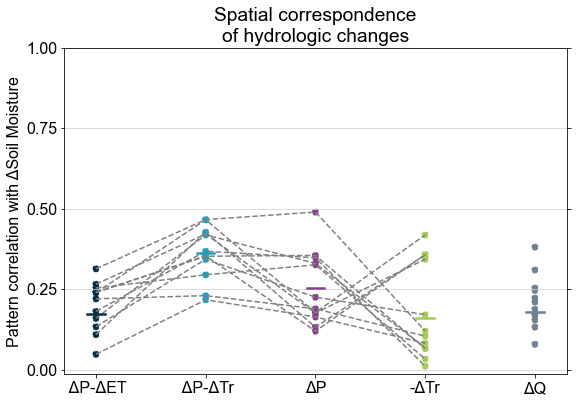

In [155]:

fig,axs = plt.subplots(1,1,figsize=(9,6))

le_col = '#219ebc'
t_col = '#a7c957'
se_col = '#bc6c25'
total_col = '#023047'
p_col = '#86408b'
q_col = 'lightcoral'
sm_col = 'slategrey'
vpd_col = '#bc3908'

ax = axs
#vs = ['r(P-ET,Q)','r(P-T,Q)','r(P,Q)','r(T,Q)','r(SM,Q)']
vs = ['r(P-ET,SM)','r(P-T,SM)','r(P,SM)','r(T,SM)','r(SM,Q)']
xlabs = [' ΔP-ΔET',' ΔP-ΔTr','ΔP','-ΔTr','ΔQ']


x = np.arange(0,5,1)
rcolors =  [total_col,le_col,p_col,t_col,'slategrey']
for model in current_ensemble:
    ax.scatter(x,qrbgc[vs].loc[model].abs(),color=rcolors,linestyle='--')
    ax.plot(x[:-1],qrbgc[vs].loc[model].abs()[:-1],color='grey',linestyle='--')

qrmeans = qrbgc[vs].mean().abs()
for ix in x:
    ax.plot([ix-0.08,ix+0.08],[qrmeans[ix],qrmeans[ix]],color=rcolors[ix],linewidth=2.5)
    
ax.set_xticks(x)        
ax.set_xticklabels(xlabs)
ax.set_ylabel(r'Pattern correlation with ΔSoil Moisture')
#ax.text(-0.08,1.02,'g)',transform=ax.transAxes,fontweight='bold')
ax.set_title('Spatial correspondence\nof hydrologic changes')
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.grid(axis='y',color='lightgrey')
ax.yaxis.set_ticks_position('both')

# ax = axs[1]
# vs = ['r(P-ET,SM)','r(P-T,SM)','r(P,SM)','r(T,SM)']
# xlabs = [' ΔP-ΔET',' ΔP-ΔTr','ΔP','-ΔTr','ΔQ']

# x = np.arange(0,4,1)
# rcolors =  [total_col,le_col,p_col,t_col]
# for model in current_ensemble:
#     ax.scatter(x,qrbgc[vs].loc[model].abs(),color=rcolors,linestyle='--')
#     ax.plot(x,qrbgc[vs].loc[model].abs(),color='grey',linestyle='--')

# qrmeans = qrbgc[vs].mean().abs()
# for ix in x:
#     ax.plot([ix-0.08,ix+0.08],[qrmeans[ix],qrmeans[ix]],color=rcolors[ix],linewidth=2.5)
    
# ax.set_xticks(x)        
# ax.set_xticklabels(xlabs)
# ax.set_ylabel(r'Pattern correlation with ΔSM')
# #ax.text(-0.08,1.02,'g)',transform=ax.transAxes,fontweight='bold')
# #ax.set_title('Spatial correspondence\nof hydrologic changes')
# ax.set_yticks([0,0.25,0.5,0.75,1])
# ax.grid(axis='y',color='lightgrey')
# ax.yaxis.set_ticks_position('both')

### temperature and soil moisture

In [12]:
### deltaTAS bgc and ctl
tas_bgc_globmean = []
tas_ctl_globmean = []
tas_rad_globmean = []
bgcrg = []

for model in current_ensemble:
    tas_bgc_globmean.append(globMean(getDelta(tas_list[model]['1pctCO2-bgc'])).tas.values)
    tas_ctl_globmean.append(globMean(getDelta(tas_list[model]['1pctCO2'])).tas.values)
    tas_rad_globmean.append(globMean(getDelta(tas_list[model]['1pctCO2-rad'])).tas.values)
    bgcrg.append(getDelta(tas_list[model]['1pctCO2-bgc']).interp_like(cesm2_landmask,method='nearest'))
    
deltaTAS_bgcds = xr.concat(bgcrg,dim='model',coords='minimal',compat='override')

In [13]:
deltaTAS_tran = []
deltaTAS_tranQdown = []
deltaTAS_tranQup = []

for model in current_ensemble:
    
    dttr = deltaTAS_bgcds.sel(model=model).where(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT < -1).tas
    deltaTAS_tran.append(globMean(dttr).values)
    deltaTAS_tranQdown.append(globMean(dttr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ < -1)).values)
    deltaTAS_tranQup.append(globMean(dttr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ > 1 )).values)
                                  

In [14]:
deltaSM_tran = []
deltaSM_tranQdown = []
deltaSM_tranQup = []

for model in current_ensemble:
    
    dsmtr = deltaSM.sel(model=model,experiment='1pctCO2-bgc').where(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT < -1).deltaSM
    deltaSM_tran.append(globMean(dsmtr).values)
    deltaSM_tranQdown.append(globMean(dsmtr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ < -1)).values)
    deltaSM_tranQup.append(globMean(dsmtr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ > 1 )).values)
                                  

In [15]:
dsm_ctl = globMean(deltaSM.sel(experiment='1pctCO2')).deltaSM.values
dsm_rad = globMean(deltaSM.sel(experiment='1pctCO2-rad')).deltaSM.values
dsm_bgc = globMean(deltaSM.sel(experiment='1pctCO2-bgc')).deltaSM.values

In [16]:
dfQs = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/clesk/data/CMIP6/C4MIP/regrid_deltas/deltafQs.nc')

deltafQ_tran = []
deltafQ_tranQdown = []
deltafQ_tranQup = []
dfqtr_bgc = []
deltafQ_tranSMdown = []
deltafQ_tranSMup = []

for model in current_ensemble:
    
    dfqtr = dfQs.sel(model=model).where(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT < -1).deltafQs
    deltafQ_tran.append(globMean(dfqtr).values)
    deltafQ_tranQdown.append(globMean(dfqtr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ < -1)).values)
    deltafQ_tranQup.append(globMean(dfqtr.where(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ > 1 )).values)  
    deltafQ_tranSMdown.append(globMean(dfqtr.where(deltaSM.sel(experiment='1pctCO2-bgc',model=model).deltaSM < -1)).values)
    deltafQ_tranSMup.append(globMean(dfqtr.where(deltaSM.sel(experiment='1pctCO2-bgc',model=model).deltaSM > 1 )).values)   
    dfqtr_bgc.append(globMean(dfQs.sel(model=model).deltafQs).values)

datfq = 100 * np.rot90(np.array([dfqtr_bgc,deltafQ_tran,deltafQ_tranQdown,deltafQ_tranQup,deltafQ_tranSMdown,deltafQ_tranSMup]))
datfq[5,0]=np.nanmedian(datfq[:,0])
datfq[5,1]=np.nanmedian(datfq[:,1])



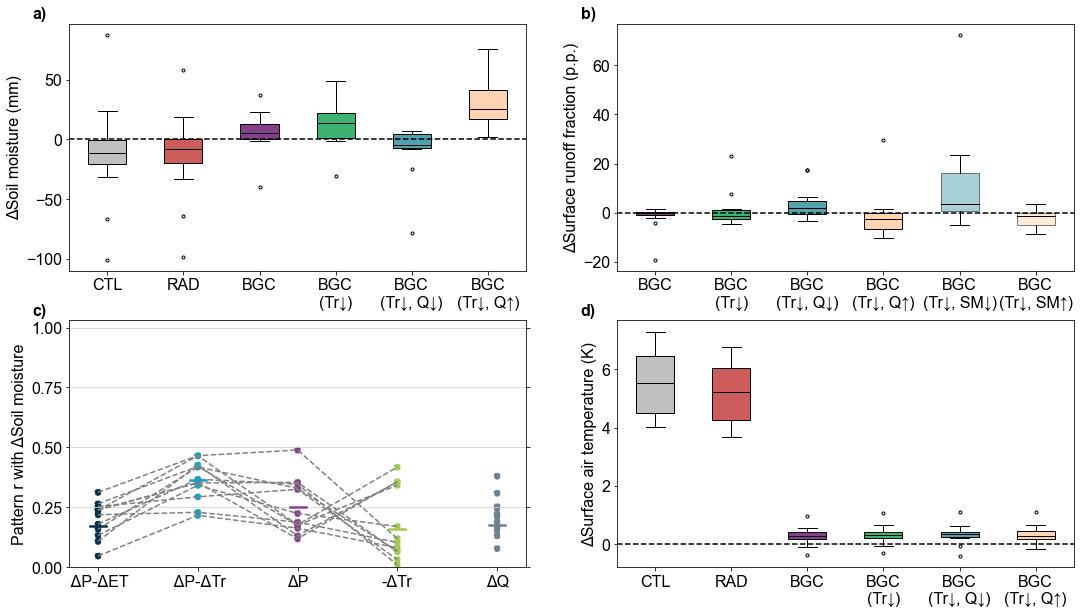

In [162]:
fig,axs = plt.subplots(2,2,figsize=(18,10))

axs = axs.reshape(-1)
le_col = '#219ebc'
t_col = '#a7c957'
se_col = '#bc6c25'
total_col = '#023047'
p_col = '#86408b'
q_col = 'lightcoral'
sm_col = 'slategrey'
vpd_col = '#bc3908'

### SM
ax = axs[0]
boxcolors = ['silver','indianred',p_col,'mediumseagreen','#52A1AD','#FFD4B2']
xticklabs = ['CTL','RAD','BGC','BGC\n(Tr↓)','BGC\n(Tr↓, Q↓)','BGC\n(Tr↓, Q↑)']
dat = np.rot90(np.array([dsm_ctl,dsm_rad,dsm_bgc,deltaSM_tran,deltaSM_tranQdown,deltaSM_tranQup]))
bp = ax.boxplot(dat,patch_artist=True,medianprops={'color': 'black'},zorder=0,sym='.');

for i,box in enumerate(bp['boxes']):
    box.set_facecolor(color=boxcolors[i])

ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(xticklabs)
ax.set_ylabel('ΔSoil moisture (mm)')
ax.axhline(0,linestyle='--',color='k')
ax.text(-0.08,1.02,'a)',transform=ax.transAxes,fontweight='bold')


ax = axs[2]
vs = ['r(P-ET,SM)','r(P-T,SM)','r(P,SM)','r(T,SM)','r(SM,Q)']
xlabs = [' ΔP-ΔET',' ΔP-ΔTr','ΔP','-ΔTr','ΔQ']

x = np.arange(0,5,1)
rcolors =  [total_col,le_col,p_col,t_col,'slategrey']
for model in current_ensemble:
    ax.scatter(x,qrbgc[vs].loc[model].abs(),color=rcolors,linestyle='--')
    ax.plot(x[:-1],qrbgc[vs].loc[model].abs()[:-1],color='grey',linestyle='--')

qrmeans = qrbgc[vs].mean().abs()
for ix in x:
    ax.plot([ix-0.08,ix+0.08],[qrmeans[ix],qrmeans[ix]],color=rcolors[ix],linewidth=2.5)
    
ax.set_xticks(x)        
ax.set_xticklabels(xlabs)
ax.set_ylabel(r'Pattern r with ΔSoil moisture')
ax.text(-0.08,1.02,'c)',transform=ax.transAxes,fontweight='bold')
#ax.set_title('Spatial correspondence\nof hydrologic changes')
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.grid(axis='y',color='lightgrey')
ax.yaxis.set_ticks_position('both')
ax.set_ylim(0,1.03)

## surface runoff fraction
ax = axs[1]
xticklabs = ['BGC','BGC\n(Tr↓)','BGC\n(Tr↓, Q↓)','BGC\n(Tr↓, Q↑)','BGC\n(Tr↓, SM↓)','BGC\n(Tr↓, SM↑)']

bp = ax.boxplot(datfq,patch_artist=True,medianprops={'color': 'black'},zorder=0,sym='.');

for i,box in enumerate(bp['boxes'][:-2]):
    box.set_facecolor(color=boxcolors[i+2])
bp['boxes'][-2].set_facecolor(color=boxcolors[-2])
bp['boxes'][-2].set_alpha(0.5)
bp['boxes'][-1].set_facecolor(color=boxcolors[-1])
bp['boxes'][-1].set_alpha(0.5)

ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(xticklabs)
ax.set_ylabel('ΔSurface runoff fraction (p.p.)')
ax.axhline(0,linestyle='--',color='k')
ax.text(-0.08,1.02,'b)',transform=ax.transAxes,fontweight='bold')

## TAS
ax = axs[3]

dat = np.rot90(np.array([tas_ctl_globmean,tas_rad_globmean,tas_bgc_globmean,deltaTAS_tran,deltaTAS_tranQdown,deltaTAS_tranQup]))
bp = ax.boxplot(dat,patch_artist=True,medianprops={'color': 'black'},zorder=0,sym='.');

for i,box in enumerate(bp['boxes']):
    box.set_facecolor(color=boxcolors[i])

xticklabs = ['CTL','RAD','BGC','BGC\n(Tr↓)','BGC\n(Tr↓, Q↓)','BGC\n(Tr↓, Q↑)']
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(xticklabs)
ax.set_ylabel('ΔSurface air temperature (K)')
ax.text(-0.08,1.02,'d)',transform=ax.transAxes,fontweight='bold')
ax.axhline(0,linestyle='--',color='k')



In [18]:
np.median(tas_bgc_globmean)

0.27871597047664365

array([[ 1.        , -0.67171676],
       [-0.67171676,  1.        ]])

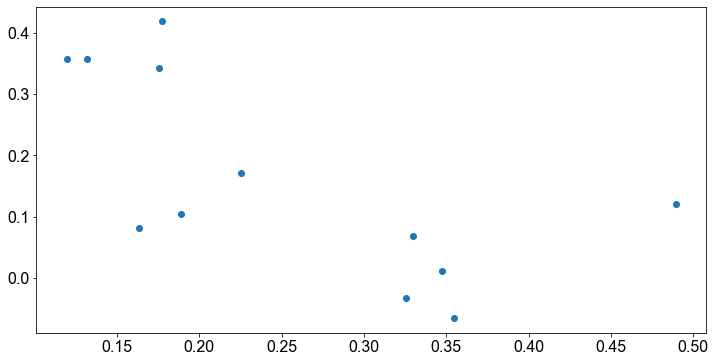

In [20]:
plt.scatter(qrbgc['r(P,SM)'],-qrbgc['r(T,SM)'])
np.corrcoef(list(qrbgc['r(P,SM)'].values),list(-qrbgc['r(T,SM)'].values))

### model genealogy pattern correlations

In [73]:
# pattern correlations model geneology
allcombs = list(itertools.combinations(current_ensemble,2))



In [130]:
grpE = ['EC-Earth3-CC','CNRM-ESM2-1','IPSL-CM6A-LR']
grpN = ['BCC-CSM2-MR','CESM2','CMCC-ESM2','NorESM2-LM']
grpO = ['CanESM5','CanESM5-CanOE','GFDL-ESM4','MIROC-ES2L','UKESM1-0-LL']

Ecombs = list(itertools.combinations(grpE,2))
Ncombs = list(itertools.combinations(grpN,2))
Ocombs = list(itertools.combinations(grpO,2))

ucombs = []

for ac in allcombs:
    if not ((ac[0] in grpN) and (ac[1] in grpN)) and not ((ac[0] in grpE) and (ac[1] in grpE)):
        ucombs.append(ac)


rqE = [xr.corr(delta_Q['1pctCO2-bgc'][ec[0]],delta_Q['1pctCO2-bgc'][ec[1]]).values for ec in Ecombs]
rqN = [xr.corr(delta_Q['1pctCO2-bgc'][nc[0]],delta_Q['1pctCO2-bgc'][nc[1]]).values for nc in Ncombs]
rqO = [xr.corr(delta_Q['1pctCO2-bgc'][uc[0]],delta_Q['1pctCO2-bgc'][uc[1]]).values for uc in ucombs]

rpE = [xr.corr(delta_P['1pctCO2-bgc'][ec[0]],delta_P['1pctCO2-bgc'][ec[1]]).values for ec in Ecombs]
rpN = [xr.corr(delta_P['1pctCO2-bgc'][nc[0]],delta_P['1pctCO2-bgc'][nc[1]]).values for nc in Ncombs]
rpO = [xr.corr(delta_P['1pctCO2-bgc'][uc[0]],delta_P['1pctCO2-bgc'][uc[1]]).values for uc in ucombs]

rtE = [xr.corr(delta_T['1pctCO2-bgc'][ec[0]],delta_T['1pctCO2-bgc'][ec[1]]).values for ec in Ecombs]
rtN = [xr.corr(delta_T['1pctCO2-bgc'][nc[0]],delta_T['1pctCO2-bgc'][nc[1]]).values for nc in Ncombs]
rtO = [xr.corr(delta_T['1pctCO2-bgc'][uc[0]],delta_T['1pctCO2-bgc'][uc[1]]).values for uc in ucombs]

In [129]:
# can also check raw dQ, rather than dQ/P, but pattern corrs are not any stronger
rqE_ = [xr.corr(deltaQ.sel(experiment='1pctCO2-bgc',model=ec[0]).deltaQ,deltaQ.sel(experiment='1pctCO2-bgc',model=ec[1]).deltaQ).values for ec in Ecombs]
rqN_ = [xr.corr(deltaQ.sel(experiment='1pctCO2-bgc',model=nc[0]).deltaQ,deltaQ.sel(experiment='1pctCO2-bgc',model=nc[1]).deltaQ).values for nc in Ncombs]
rqO_ = [xr.corr(deltaQ.sel(experiment='1pctCO2-bgc',model=uc[0]).deltaQ,deltaQ.sel(experiment='1pctCO2-bgc',model=uc[1]).deltaQ).values for uc in ucombs]


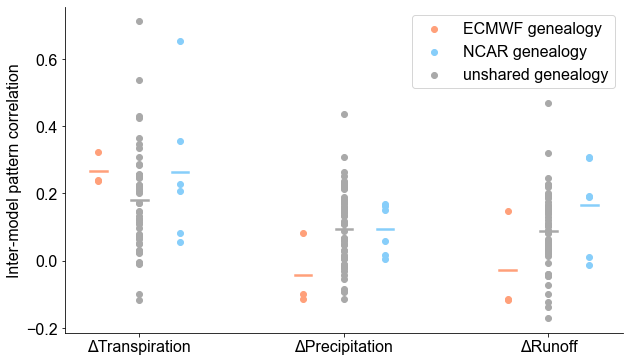

In [163]:
Ecol = 'lightsalmon'
Ncol = 'lightskyblue'
Ocol = 'darkgrey'

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(-0.2+np.ones(len(rtE)),rtE,color=Ecol)
ax.scatter(0.2+np.ones(len(rtN)),rtN,color=Ncol)
ax.scatter(np.ones(len(rtO)),rtO,color=Ocol)

ax.scatter(-0.2+2*np.ones(len(rpE)),rpE,color=Ecol)
ax.scatter(0.2+2*np.ones(len(rpN)),rpN,color=Ncol)
ax.scatter(2*np.ones(len(rpO)),rpO,color=Ocol)

s0=ax.scatter(-0.2+3*np.ones(len(rqE)),rqE,color=Ecol)
s1=ax.scatter(0.2+3*np.ones(len(rqN)),rqN,color=Ncol)
s2=ax.scatter(3*np.ones(len(rqO)),rqO,color=Ocol)

ax.plot([1-0.2-0.04,1-0.2+0.04],[np.mean(rtE),np.mean(rtE)],color=Ecol,linewidth=2.5)
ax.plot([1+0.2-0.04,1+0.2+0.04],[np.mean(rtN),np.mean(rtN)],color=Ncol,linewidth=2.5)
ax.plot([1-0.04,1+0.04],[np.mean(rtO),np.mean(rtO)],color=Ocol,linewidth=2.5)

ax.plot([2-0.2-0.04,2-0.2+0.04],[np.mean(rpE),np.mean(rpE)],color=Ecol,linewidth=2.5)
ax.plot([2+0.2-0.04,2+0.2+0.04],[np.mean(rpN),np.mean(rpN)],color=Ncol,linewidth=2.5)
ax.plot([2-0.04,2+0.04],[np.mean(rpO),np.mean(rpO)],color=Ocol,linewidth=2.5)

ax.plot([3-0.2-0.04,3-0.2+0.04],[np.mean(rqE),np.mean(rqE)],color=Ecol,linewidth=2.5)
ax.plot([3+0.2-0.04,3+0.2+0.04],[np.mean(rqN),np.mean(rqN)],color=Ncol,linewidth=2.5)
ax.plot([3-0.04,3+0.04],[np.mean(rqO),np.mean(rqO)],color=Ocol,linewidth=2.5)

ax.legend([s0,s1,s2],['ECMWF genealogy','NCAR genealogy','unshared genealogy'])
ax.set_ylabel('Inter-model pattern correlation')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['ΔTranspiration','ΔPrecipitation','ΔRunoff'])

ax.spines[['right', 'top']].set_visible(False)

In [161]:
# note that variation in pattern correlation is generally less than one SD (as noted in supplementary text)
np.std(rtO)

0.14748529404997424

## Figure 3

In [13]:
load_path = '/dartfs-hpc/rc/lab/C/CMIG/clesk/projects/plcl/data/piC_pr_means/'

model = current_ensemble[1]
varname = 'pr'
experiment='1pctCO2-bgc'

pr_sig_list = []

upper_thresh = 0.95*500
lower_thresh = 0.05*500

for model in current_ensemble:
    print(model)
    smeans = xr.open_dataset('{}/{}.{}.{}.{}.{}.nc'.format(load_path, varname, model, 'piControl', time, 'sampleMeansN500'))
    if model == 'EC-Earth3-CC':
        smeans = smeans.assign_coords({"lat":pr_list[model][experiment].lat})
    delta_gt_mean = (getDelta(pr_list[model][experiment]).pr > smeans).sum(dim='water_year').pr
    sig_high = delta_gt_mean > upper_thresh
    sig_low = delta_gt_mean < lower_thresh
    sig_class = (-1*sig_low + sig_high).interp_like(deltaP.sel(experiment=experiment,model=model),method='nearest')
    pr_sig_list.append(sig_class)

pr_sig = xr.concat(pr_sig_list,dim='model')


#pr_sig = pr_sig_ores.interp_like(deltaP.sel(experiment=experiment,model=model),method='nearest')

BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
EC-Earth3-CC
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
NorESM2-LM
UKESM1-0-LL


In [17]:
#AGREEMENT
def pr_agreement(data, e, thresh_agree=2/3):

    #varname = list(dict(data.data_vars).keys())[0]
    agreement_ds_list = []

    # compute fractional agreement (N models >/< tol)
    agreeneg = data==-1
    frac_agreeneg = agreeneg.sum(dim='model')/len(current_ensemble)
    agreepos = data==1
    frac_agreepos = agreepos.sum(dim='model')/len(current_ensemble)
    agreeNS = data==0
    frac_agreeNS = agreeNS.sum(dim='model')/len(current_ensemble)
    
    frac_agreesig = (agreepos.sum(dim='model')+agreeneg.sum(dim='model'))/len(current_ensemble)

    # classify agreement

    #agree_map = #0 if fraction models agree neg > thresh_agree, 1 if agree noc, 2 if agree +, 3 if disagree
    agreement=np.nan*np.zeros([data.lat.shape[0],data.lon.shape[0]])
    agreement[frac_agreeneg>=thresh_agree] = -1   
    agreement[frac_agreeNS>=thresh_agree] = 0
    agreement[frac_agreepos>=thresh_agree] = 1
    agreement[(frac_agreesig>=thresh_agree) & (frac_agreeneg<thresh_agree) ] = 2
    
    agreement[(frac_agreeneg<thresh_agree) & (frac_agreepos<thresh_agree) & (frac_agreeNS<thresh_agree) & (frac_agreesig<thresh_agree)] = 3

    # put agreement in a new ds
    dvs = {'agreement':(['lat','lon'],agreement)}
    crds = {'lon':(['lon'],data.lon.data),'lat':(['lat'],data.lat.data),'experiment':e}

    ds_agreement = xr.Dataset(data_vars=dvs,coords=crds)

    
    return ds_agreement

In [18]:
def prCaseAreaFrac(data):
    
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data
    ns_area = (data==0).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
    neg_area = (data==-1).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
    pos_area = (data==1).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
    

    return [neg_area/total_area,ns_area/total_area,pos_area/total_area]

def prAgrAreaFrac(data):
    
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data

    neg_area = (data==-1).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon'])
    pos_area = (data==1).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']) 
    ns_area =  (data==0).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon'])
    sig_area =  (data==2).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon'])

    return [(neg_area/total_area).agreement.data.round(2),
            (pos_area/total_area).agreement.data.round(2),
            (ns_area/total_area).agreement.data.round(2),
            (sig_area/total_area).agreement.data.round(2)]


In [23]:
x=np.array([prCaseAreaFrac(pr_sig.sel(model=model)) for model in current_ensemble])
x[:,2].mean()

0.13829934940820307

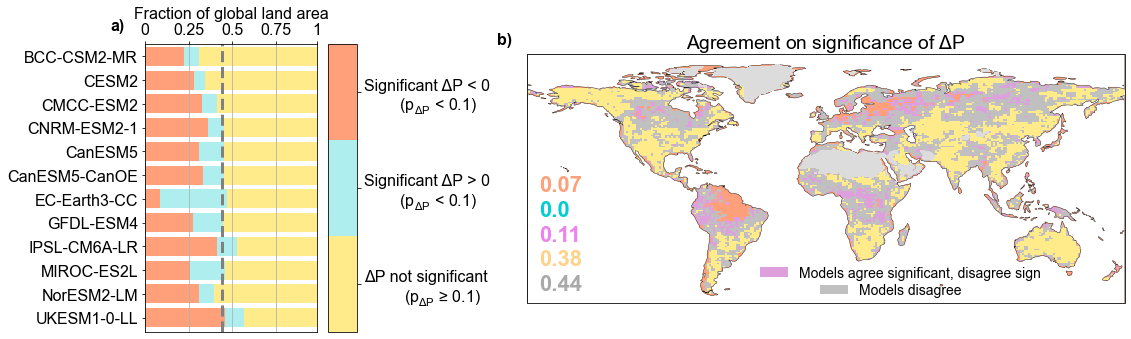

In [20]:
fig = plt.figure(figsize=(16,5))
gs = GridSpec(3, 3)
ax = fig.add_subplot(gs[:, 0])
pdp = r'$p_{ΔP}$'

caselabs = ['Significant ΔP < 0\n        ('+pdp+' < 0.1)','Significant ΔP > 0\n        ('+pdp+' < 0.1)','ΔP not significant\n         ('+pdp+' ≥ 0.1)']

### a)
clrs_pr = ['lightsalmon','paleturquoise','#FFEB8A']
cmap_pr = mpl.colors.ListedColormap(clrs_pr) 
bounds = np.arange(-1,3,1)
norm_pr = mpl.colors.BoundaryNorm(bounds, cmap_pr.N)

for i,model in enumerate(current_ensemble):
    
    
    caseareafrac = prCaseAreaFrac(pr_sig.sel(model=model))
    ax.barh(i,caseareafrac[0],color=clrs_pr[0])
    ax.barh(i,caseareafrac[2],left=caseareafrac[0],color=clrs_pr[1])
    ax.barh(i,caseareafrac[1],left=caseareafrac[0]+caseareafrac[2],color=clrs_pr[2])

ax.set_yticks(np.arange(0,len(current_ensemble),1))
ax.set_yticklabels(current_ensemble)
ax.set_xticks([0,0.25,0.5,0.75,0.99])
ax.set_xticklabels([0,0.25,0.5,0.75,1])

ax.set_xlim([0,.99])
ax.set_ylim([-0.5,len(current_ensemble)-0.4])
ax.set_xlabel('Fraction of global land area')
ax.invert_yaxis()

ensmeansig = np.array([prCaseAreaFrac(pr_sig.sel(model=model)) for model in current_ensemble])[:,[0,2]].mean(axis=0).sum()
ax.axvline(ensmeansig,color='grey',linestyle='--',linewidth=3)

qtsm = plt.cm.ScalarMappable(norm=norm_pr,cmap=cmap_pr)
cb = plt.colorbar(qtsm,ax=ax,aspect=10)
cb.ax.set_yticks([-0.5,0.5,1.5])
cb.ax.set_yticklabels(caselabs,rotation=0);
cb.ax.invert_yaxis()

ax.text(-0.2,1.05,'a)',transform=ax.transAxes,fontweight='bold')
#ax.set(anchor=(0.2,-0.1))

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.grid(axis='x')
#ax.set_title(r'Significance of $\Delta$P')

### b)
ax = fig.add_subplot(gs[:, 1:],projection=ccrs.PlateCarree())

pr_agr = pr_agreement(pr_sig,experiment)

clrs_prag = ['lightsalmon','#FFEB8A','paleturquoise','plum','silver']
cmap_prag = mpl.colors.ListedColormap(clrs_prag) 
bounds = np.arange(-1,5,1)
norm_prag = mpl.colors.BoundaryNorm(bounds, cmap_prag.N)


pl = pr_agr.agreement.plot(cmap=cmap_prag,norm=norm_prag,transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False)
b0 = ax.bar(0,0,color='silver')
b1 = ax.bar(0,0,color='plum')


l1=ax.legend([b0[0]],['Models disagree'],
          loc=(0.48,0.00),fontsize=14,frameon=False)

ax.legend([b1[0]],['Models agree significant, disagree sign'],
          loc=(0.38,0.07),fontsize=14,frameon=False)

plt.gca().add_artist(l1)

#cb.ax.set_xticks(np.arange(-0.5,3.5,1))
#cb.ax.set_xticklabels(['Agree:\nΔP < 0, p < 0.1','Agree: N.S.','Agree:\nΔP > 0, p < 0.1','Models Disagree'] )

ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
ax.set_extent((-180,180,-60,90), crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) 
ax.set_title(r'Agreement on significance of $\Delta$P') 
ax.set(anchor=(0.5,0.75))

ax.text(0.02,0.45,prAgrAreaFrac(pr_agr)[0],transform=ax.transAxes,weight='bold',color=clrs_prag[0],fontsize=22)
ax.text(0.02,0.35,prAgrAreaFrac(pr_agr)[1],transform=ax.transAxes,weight='bold',color='darkturquoise',fontsize=22)
ax.text(0.02,0.15,prAgrAreaFrac(pr_agr)[2],transform=ax.transAxes,weight='bold',color='#FFD289',fontsize=22)
ax.text(0.02,0.25,prAgrAreaFrac(pr_agr)[3],transform=ax.transAxes,weight='bold',color='violet',fontsize=22)
ax.text(0.02,0.05,np.round(1-sum(prAgrAreaFrac(pr_agr)),2),transform=ax.transAxes,weight='bold',color='darkgrey',fontsize=22)

ax.text(-0.05,1.04,'b)',transform=ax.transAxes,fontweight='bold')

fig.canvas.draw()
plt.tight_layout()

#plt.savefig(figure_dir+'Fig3.pdf',bbox_inches='tight')
#plt.savefig(figure_dir+'Fig3.png',bbox_inches='tight')    

### Figure 4

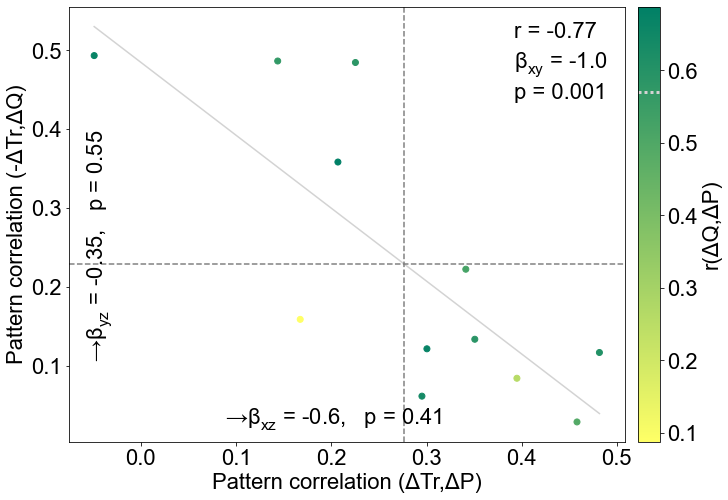

In [49]:
# panel a)
experiment = '1pctCO2-bgc'
fig,ax = plt.subplots(figsize=(12,8))

rT_Q = [xr.corr(delta_Q[experiment][model],-delta_T[experiment][model]).data for model in current_ensemble]
rT_P = [xr.corr(delta_P[experiment][model],delta_T[experiment][model]).data for model in current_ensemble]
rP_Q = [xr.corr(delta_P[experiment][model],delta_Q[experiment][model]).data for model in current_ensemble]

s = ax.scatter(rT_P,rT_Q,c=rP_Q,cmap='summer_r')
ax.set_xlabel('Pattern correlation (ΔTr,ΔP)')
ax.set_ylabel('Pattern correlation (-ΔTr,ΔQ)')

pfit = np.polyfit(rT_P, rT_Q, 1)
a = pfit[0]
b = pfit[1]
x_fitted = np.linspace(np.min(rT_P), np.max(rT_P), 100)
y_fitted = a * x_fitted + b
ax.plot(x_fitted,y_fitted,color='lightgrey')
ax.axhline(np.mean(rT_Q),linestyle='--',color='grey')
ax.axvline(np.mean(rT_P),linestyle='--',color='grey')

ax.text(0.8,0.93,'r = ' + str(np.corrcoef(rT_Q,rT_P)[0,1].round(2)),transform=ax.transAxes)
ax.text(0.8,0.86,r'$\beta_{xy}$ = -1.0',transform=ax.transAxes)
ax.text(0.8,0.79,'p = 0.001',transform=ax.transAxes)

ax.text(0.28,0.04,r'→$\beta_{xz}$ = -0.6,   p = 0.41',transform=ax.transAxes)
ax.text(0.03,0.21,r'→$\beta_{yz}$ = -0.35,   p = 0.55',transform=ax.transAxes,rotation=90)

#ax.text(-0.1,0.95,'a)',transform=ax.transAxes,fontweight='bold')



cb = plt.colorbar(s,ax=ax,label='r(ΔQ,ΔP)',pad=0.02)
cb.ax.axhline(0.57,linestyle=(0,(1,1)),linewidth=3,color='lightgrey')

#plt.savefig(figure_dir+'Fig4.pdf',bbox_inches='tight')
#plt.savefig(figure_dir+'Fig4.png',bbox_inches='tight')

In [ ]:
# bivariate regression statistics for axis labels
df = pd.DataFrame(data=np.array([rT_P,rT_Q,rP_Q]),index=['rTP','rTQ','rPQ']).transpose()
fit = stm.ols(formula = 'rTQ ~ rTP',data=df).fit()
fit.summary()

In [ ]:
# multivariate regression statistics for axis labels
df = pd.DataFrame(data=np.array([rT_P,rT_Q,rP_Q]),index=['rTP','rTQ','rPQ']).transpose()
fit = stm.ols(formula = 'rPQ ~ rTQ + rTP',data=df).fit()
fit.summary()

### Figure 5

In [ ]:
# one-tailed test for deltaP relative to pre-industrial 
load_path = '/dartfs-hpc/rc/lab/C/CMIG/clesk/projects/plcl/data/piC_pr_means/'

model = current_ensemble[1]
varname = 'pr'
experiment='1pctCO2-bgc'

pr_sig_list = []

upper_thresh = 0.95*500
lower_thresh = 0.1*500

for model in current_ensemble:
    print(model)
    smeans = xr.open_dataset('{}/{}.{}.{}.{}.{}.nc'.format(load_path, varname, model, 'piControl', time, 'sampleMeansN500'))
    if model == 'EC-Earth3-CC':
        smeans = smeans.assign_coords({"lat":pr_list[model][experiment].lat})
    delta_gt_mean = (getDelta(pr_list[model][experiment]).pr > smeans).sum(dim='water_year').pr
    sig_high = delta_gt_mean > upper_thresh
    sig_low = delta_gt_mean < lower_thresh
    sig_class = (-1*sig_low + sig_high).interp_like(deltaP.sel(experiment=experiment,model=model),method='nearest')
    pr_sig_list.append(sig_class)

pr_sig_bottom10 = xr.concat(pr_sig_list,dim='model')




BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
EC-Earth3-CC
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
NorESM2-LM
UKESM1-0-LL


In [50]:
#AGREEMENT
def dqp_agreement(data, e, thresh_agree=0.67):
    """
    This function takes in ensemble var deltas and classifies ensemble agreement on sign of change.  
    Currently, within model change definition is defined as <-0.5SD or >0.5SD, parameter 'tol'. No change is between -0.5 and 0.5 SD.
    Agreement is defined as at least two thirds of models showing that change (+, -, no change)
    The classification codes:
    -agree negative as 0 (if fraction models agree neg > thresh_agree)
    -1 if agree no change
    -2 if agree +
    -3 if disagree (less than two-thirds agreement on either +, -, or no change)
    
    Params:
    ------
        var_std_deltas_list (list of xr datasets with standardized deltas (can be non-standardized too)
        
        tol (tolerance about zero for +, -, or no change, in SD)
        
        thresh_agree (fraction of models that must agree on +, -, or no change, else classify as disagree)
        
    Returns:
    -------
        xarray DS's of agreement for each experiment above        
    """    
    #varname = list(dict(data.data_vars).keys())[0]
    agreement_ds_list = []
    
    # # loop over expriments
    # for e in exp:


    # compute fractional agreement (N models >/< tol)
    agree1 = data==-1
    frac_agree1 = agree1.sum(dim='model')/len(current_ensemble)
    agree2 = data==1
    frac_agree2 = agree2.sum(dim='model')/len(current_ensemble)

    # classify agreement

    #agree_map = #0 if fraction models agree neg > thresh_agree, 1 if agree noc, 2 if agree +, 3 if disagree
    agreement=np.nan*np.zeros([data.lat.shape[0],data.lon.shape[0]])
    agreement[frac_agree1>thresh_agree] = 0
    agreement[frac_agree2>thresh_agree] = 1
    
    agreement[(frac_agree1<thresh_agree) & (frac_agree2<thresh_agree)]  = 2

    # put agreement in a new ds
    dvs = {'agreement':(['lat','lon'],agreement)}
    crds = {'lon':(['lon'],data.lon.data),'lat':(['lat'],data.lat.data),'experiment':e}

    ds_agreement = xr.Dataset(data_vars=dvs,coords=crds)
    
    return ds_agreement

In [51]:
def pqAreaFracRel(data):
    
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data
    case_frac = []
    
    for b in [-1,1]:

        case_area = (data==b).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
        case_frac.append(case_area/total_area)

    return [cf/sum(case_frac) for cf in case_frac]

def dqpAreaFracRel(data):
    
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon']).data
    case_frac = []
    
    for b in range(1,7):

        case_area = (data==b).where(landmask).where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(data.lat))).sum(dim=['lat','lon']).data 
        case_frac.append(case_area/total_area)

    return [cf/sum(case_frac) for cf in case_frac]

In [52]:
# allocate runoff change to precip versus partitiong change
baseQ_P = baseQds/basePds
part_only = basePds*(deltaQ_P.sel(experiment=experiment))
delta_only = deltaP.sel(experiment=experiment)*baseQ_P
part_delta = deltaP.sel(experiment=experiment)*deltaQ_P.sel(experiment=experiment)

In [53]:
#execute classification of runoff changes, relative to P* (crit)
smt_dqp = {}
tol = 0

for i,model in enumerate(current_ensemble):
    
    
    dP = deltaP.sel(model=model,experiment=experiment).deltaPr 
    dQ = deltaQ.sel(model=model,experiment=experiment).deltaQ 
    crit = (delta_only+part_delta).deltaPr.sel(model=model)
    prsig = pr_sig_bottom10.sel(model=model)
    
    
    #Q increases less than crit
    c1 = 1 * ( (dQ>tol) & (dQ<=crit) ) 
    
    #Q and P decrease, P not significant, Q decreases more than crit, 
    c2 = 2 * ( (dQ<tol) & (dQ<=crit) & (prsig > -1) )   
    
    #Q and P decrease, P significant, Q decreases more than crit, 
    c3 = 3 * ( (dQ<tol) & (dQ<=crit) & (prsig == -1)) 
    
    # cause drought: Q decreases less than crit, P significant
    c4 = 4 * ( (dQ<tol) &   (dQ>=crit) & (prsig == -1) )
    
    # limit drought: Q decreases less than crit, P not significant
    c5 = 5 * ( (dQ<tol) & (dQ>crit) & (prsig==0) )
    
    # clear boost: Q increases more than crit
    c6 = 6 * ( (dQ>tol) & (dQ>crit) )
    
    smt_dqp[model] = c1+c2+c3+c4+c5+c6


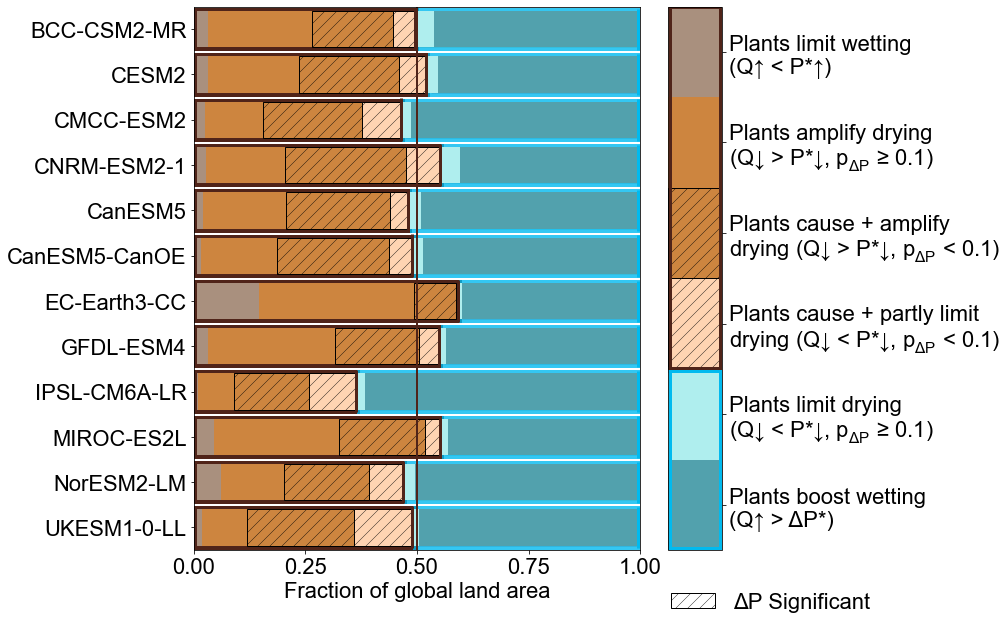

In [54]:
fig, ax = plt.subplots(figsize=(10,10))

clrs_smt = ['#A9907E','peru','peru','#FFD4B2','paleturquoise','#52A1AD']
cmap_smt = mpl.colors.ListedColormap(clrs_smt) 
# define the bins and normalize
bounds = np.arange(0, 7,1)
norm_smt = mpl.colors.BoundaryNorm(bounds, cmap_smt.N)
pdp = r'$p_{ΔP}$'

pqcaselabs_top = ['0 < Q↑ < P*↑','Q↓ > ↓P*','Q↓ < P*','Q↓ > P*','Limit drought','Boost']
pqcaselabs = ['Plants limit wetting\n(Q↑ < P*↑)',\
              'Plants amplify drying\n(Q↓ > P*↓, ' + pdp + ' ≥ 0.1)',\
              'Plants cause + amplify\ndrying (Q↓ > P*↓, ' + pdp + ' < 0.1)',\
              'Plants cause + partly limit\ndrying (Q↓ < P*↓, ' + pdp + ' < 0.1)',\
              'Plants limit drying\n(Q↓ < P*↓, ' + pdp + ' ≥ 0.1)',\
              'Plants boost wetting\n(Q↑ > ΔP*)']

#pqcaselabs = [top + '\n' + pqcaselabs_bottom[i] for i,top in enumerate(pqcaselabs_top)]
#pqcaselabs = ['Q↓, P↑','Q↑ < P↑','Q↓ > P↓','Q↑ > P↑','Q↑, P↓']
              
hatchcolor = 'black'

for i,model in enumerate(current_ensemble):
    
    caseareafrac = dqpAreaFracRel(smt_dqp[model])
    #caseareafrac = [caf[0],caf[2],caf[1],caf[3],caf[4]]
    #DDshift = caseareafrac[2]*DD_prsig[i]
    
    ax.barh(i,sum(caseareafrac[0:4]),edgecolor='#502419',linewidth=7,alpha=1)
    ax.barh(i,sum(caseareafrac[4:]),left=sum(caseareafrac[0:4])+0.01,edgecolor='#01BAEF',linewidth=7,alpha=0.8)  ##314CB6
    ax.vlines(sum(caseareafrac[0:4]),ymin=i-0.47,ymax=i+0.46,color='#502419',alpha=1,linewidth=3)
    ax.vlines(0.004,ymin=i-0.45,ymax=i+0.45,color='#502419',alpha=1,linewidth=3)
    ax.vlines(0.996,ymin=i-0.45,ymax=i+0.46,color='#01BAEF',alpha=1,linewidth=3)
     
    ax.barh(i,caseareafrac[0],color=clrs_smt[0])
    ax.barh(i,caseareafrac[1],left=caseareafrac[0],color=clrs_smt[1])
    ax.barh(i,caseareafrac[2],left=sum(caseareafrac[0:2]),color=clrs_smt[2])
    ax.barh(i,caseareafrac[3],left=sum(caseareafrac[0:3]),color=clrs_smt[3])
    ax.barh(i,caseareafrac[4],left=sum(caseareafrac[0:4]),color=clrs_smt[4])
    ax.barh(i,caseareafrac[5],left=sum(caseareafrac[0:5]),color=clrs_smt[5])

    #sig hatching for DD
    ax.barh(i,caseareafrac[2],color=clrs_smt[2],left=sum(caseareafrac[0:2]),edgecolor=hatchcolor,hatch='//')
    ax.barh(i,caseareafrac[3],color=clrs_smt[3],left=sum(caseareafrac[0:3]),edgecolor=hatchcolor,hatch='//')
    b0=ax.barh(-1,caseareafrac[2],color='white',left=sum(caseareafrac[0:2]),edgecolor=hatchcolor,hatch='//')
    
ax.legend([b0],['ΔP Significant'],frameon=False,loc=(1.05,-0.13))

ax.set_yticks(np.arange(0,len(current_ensemble),1))
ax.set_yticklabels(current_ensemble)
ax.set_xlim([0,1])
ax.set_ylim([-0.5,len(current_ensemble)-0.5])
ax.set_xlabel('Fraction of global land area')
ax.invert_yaxis()
ax.set_xticks([0,0.25,0.5,0.75,1.0])

ax.axvline(0.5,color='black',linestyle='--',linewidth=2)
afraclist = [dqpAreaFracRel(smt_dqp[model]) for model in current_ensemble]

ens_mean_tapoff = np.array(np.array(afraclist).mean(axis=0))[0:4].sum() # + np.mean(np.array(afraclist)[:,2]*DD_prsig)
ax.axvline(ens_mean_tapoff,color='#502419',linewidth=2)

smtsm = plt.cm.ScalarMappable(norm=norm_smt,cmap=cmap_smt)
cb = plt.colorbar(smtsm,ax=ax,aspect=10)
cb.ax.set_yticks(np.arange(0.5,len(clrs_smt)+0.5,1))
cb.ax.set_yticklabels(pqcaselabs,rotation=0);
cb.ax.invert_yaxis()

cb.ax.hlines(0.01,xmin=0,xmax=1,color='#502419',alpha=1,linewidth=3)
cb.ax.hlines(3.99,xmin=0,xmax=1,color='#502419',alpha=1,linewidth=3)
cb.ax.vlines(0.03,ymin=0,ymax=3.99,color='#502419',alpha=1,linewidth=3)
cb.ax.vlines(0.96,ymin=0,ymax=3.99,color='#502419',alpha=1,linewidth=3)

cb.ax.hlines(4.02,xmin=0,xmax=1,color='#01BAEF',alpha=1,linewidth=3)
cb.ax.hlines(5.98,xmin=0,xmax=1,color='#01BAEF',alpha=1,linewidth=3)
cb.ax.vlines(0.03,ymin=4.02,ymax=5.98,color='#01BAEF',alpha=1,linewidth=3)
cb.ax.vlines(0.96,ymin=4.02,ymax=5.98,color='#01BAEF',alpha=1,linewidth=3)

import matplotlib.patches as patches
rect1 = patches.Rectangle([0,2],2,1,facecolor=clrs_smt[2],edgecolor=hatchcolor,hatch='//')
rect2 = patches.Rectangle([0,3],2,1,facecolor=clrs_smt[3],edgecolor=hatchcolor,hatch='//')
cb.ax.add_patch(rect1)
cb.ax.add_patch(rect2)

# cb.ax.text(0.37,4.55,'Plants boost Q',color='black',alpha=0.8,fontweight='bold',rotation=90)
# cb.ax.text(0.37,2.2,'Plants impinge Q',color='black',alpha=0.8,fontweight='bold',rotation=90)

#plt.savefig(figure_dir+'Fig5.pdf',bbox_inches='tight')
#plt.savefig(figure_dir+'Fig5.png',bbox_inches='tight')